PART B: DEEP LEARNING VIDEO CLASSIFICATION (REAL DATA)

This script implements:
1. 2D CNN (ResNet-18) + Temporal Pooling
2. 3D CNN (R(2+1)D-18)

Dataset:
- UCF-style directory
- Predefined train/test splits

Evaluation:
- Accuracy
- Precision (macro)
- Recall (macro)
- F1-score (macro)
- Confusion Matrix
- Training time
- Inference time per video

Author: 2024ab05275

In [3]:
pip install -r requirements.txt

INFO: pip is looking at multiple versions of opencv-python-headless to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 MB 27.2 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [9]:
# ==========================================================
# IMPORTS
# ==========================================================
import os
import cv2
import time
import torch
import numpy as np
from pathlib import Path
from typing import List, Tuple
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# ==========================================================
# CONFIGURATION
# ==========================================================
# Current file is inside /code
CODE_DIR = Path.cwd()

# Project root is one level above
PROJECT_ROOT = CODE_DIR.parent

DATASET_ROOT = PROJECT_ROOT / "dataset"
SPLITS_DIR = DATASET_ROOT / "splits"

LOCAL_WEIGHTS = os.path.join(PROJECT_ROOT, "model", "resnet18-f37072fd.pth")

# Safety checks (VERY IMPORTANT)
assert DATASET_ROOT.exists(), f"Dataset not found at {DATASET_ROOT}"
assert SPLITS_DIR.exists(), f"Splits folder not found at {SPLITS_DIR}"

print(f"✅ Project root: {PROJECT_ROOT}")
print(f"✅ Dataset root: {DATASET_ROOT}")

NUM_FRAMES = 16                 # Frames sampled per video
IMG_SIZE = (224, 224)           # Required for pretrained CNNs
BATCH_SIZE = 8
EPOCHS = 5
LEARNING_RATE = 1e-4

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"\n🚀 Running on device: {DEVICE}")

✅ Project root: /home/jovyan/va-dataset/Student_2024ab05275_Video_Classification
✅ Dataset root: /home/jovyan/va-dataset/Student_2024ab05275_Video_Classification/dataset

🚀 Running on device: cuda


In [3]:
# ==========================================================
# CLASS MAPPING (Derived from folder names)
# ==========================================================
CLASS_NAMES = sorted([
    d.name for d in DATASET_ROOT.iterdir()
    if d.is_dir() and d.name.startswith("class_")
])

CLASS_TO_IDX = {cls: i for i, cls in enumerate(CLASS_NAMES)}
NUM_CLASSES = len(CLASS_NAMES)

print("\n📌 Class mapping:")
for k, v in CLASS_TO_IDX.items():
    print(f"  {k} → {v}")


📌 Class mapping:
  class_1_Basketball → 0
  class_2_Biking → 1
  class_3_WalkingWithDog → 2


In [4]:
# ==========================================================
# VIDEO PREPROCESSING
# ==========================================================
"""
- OpenCV used for video loading
- Uniform frame sampling
- Resize to 224×224
- ImageNet normalization (mandatory for pretrained models)
"""

imagenet_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

def load_video(video_path, num_frames=NUM_FRAMES):

    # Extract path after "dataset"
    relative_path = video_path.parts[video_path.parts.index("dataset") + 1 :]
    print(f"* Processing Video : {'/'.join(relative_path)}")
    
    cap = cv2.VideoCapture(str(video_path))
    frames = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = cv2.resize(frame, IMG_SIZE)
        frames.append(frame)

    cap.release()

    # Uniform temporal sampling
    if len(frames) >= num_frames:
        idx = np.linspace(0, len(frames) - 1, num_frames).astype(int)
        frames = [frames[i] for i in idx]
    else:
        while len(frames) < num_frames:
            frames.append(frames[-1])

    frames = [imagenet_transform(f) for f in frames]
    return torch.stack(frames)  # (T, C, H, W)

In [5]:
# ==========================================================
# LOAD DATA USING OFFICIAL SPLITS
# ==========================================================
def load_split(split_file):
    videos, labels = [], []

    with open(split_file, "r") as f:
        lines = f.read().splitlines()

    for line in lines:
        video_path = DATASET_ROOT / line
        class_name = line.split("/")[0]
        label = CLASS_TO_IDX[class_name]

        videos.append(load_video(video_path))
        labels.append(label)

    return torch.stack(videos), torch.tensor(labels)

print("\n-----------------------------------------------")
print("📂 Loading training data...")
print("-----------------------------------------------\n")

X_train, y_train = load_split(SPLITS_DIR / "train.txt")

print("\n-----------------------------------------------")
print("📂 Loading testing data...")
print("-----------------------------------------------\n")

X_test, y_test = load_split(SPLITS_DIR / "test.txt")

print("\n-----------------------------------------------")
print("✅ Dataset summary:")
print("-----------------------------------------------\n")

print(f"* Training videos: {len(X_train)}")
print(f"* Testing videos : {len(X_test)}")
print(f"* Classes        : {NUM_CLASSES}")


-----------------------------------------------
📂 Loading training data...
-----------------------------------------------

* Processing Video : class_1_Basketball/v_Basketball_g13_c04.avi
* Processing Video : class_1_Basketball/v_Basketball_g15_c05.avi
* Processing Video : class_1_Basketball/v_Basketball_g19_c05.avi
* Processing Video : class_1_Basketball/v_Basketball_g17_c01.avi
* Processing Video : class_1_Basketball/v_Basketball_g12_c01.avi
* Processing Video : class_1_Basketball/v_Basketball_g20_c02.avi
* Processing Video : class_1_Basketball/v_Basketball_g15_c07.avi
* Processing Video : class_1_Basketball/v_Basketball_g15_c02.avi
* Processing Video : class_1_Basketball/v_Basketball_g15_c06.avi
* Processing Video : class_1_Basketball/v_Basketball_g18_c01.avi
* Processing Video : class_1_Basketball/v_Basketball_g16_c02.avi
* Processing Video : class_1_Basketball/v_Basketball_g21_c05.avi
* Processing Video : class_1_Basketball/v_Basketball_g12_c02.avi
* Processing Video : class_1_B

In [10]:
# ==========================================================
# VIDEO DATASET WITH OPTIONAL DATA AUGMENTATION
# ==========================================================
class VideoDataset(Dataset):
    """
    Custom PyTorch Dataset for video classification.

    Each sample consists of:
    - A video: sequence of frames (Tensor)
    - A label: class index or class name

    Data augmentation:
    - Random horizontal flip is applied
      ONLY when train=True
    """

    def __init__(
        self,
        X: List[torch.Tensor],
        y: List[int],
        train: bool = True,
    ) -> None:
        """
        Initialize the dataset.

        Args:
            X (List[Tensor]):
                List of videos.
                Each video is a Tensor of shape:
                (num_frames, channels, height, width)

            y (List[int]):
                Corresponding labels for each video.

            train (bool):
                If True:
                    - Apply data augmentation (horizontal flip)
                If False:
                    - No augmentation (used for validation/testing)
        """
        # Store videos
        self.X = X

        # Store labels
        self.y = y

        # Flag to control augmentation behavior
        self.train = train

        # Define spatial augmentation:
        # Randomly flips an image horizontally with 50% probability
        #
        # IMPORTANT:
        # - This does NOT add new pixels
        # - It only rearranges existing pixels
        self.flip = transforms.RandomHorizontalFlip(p=0.5)

    def __len__(self) -> int:
        """
        Return the total number of samples in the dataset.

        This method is required by PyTorch's Dataset class
        so that DataLoader knows how many samples exist.
        """
        return len(self.X)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int]:
        """
        Retrieve one sample from the dataset.

        Args:
            idx (int):
                Index of the sample to retrieve.

        Returns:
            Tuple[Tensor, int]:
                - video: Tensor of shape
                  (num_frames, channels, height, width)
                - label: corresponding class label
        """
        # Fetch the video at the given index
        video = self.X[idx]

        # Apply data augmentation ONLY during training
        if self.train:
            # Apply horizontal flip independently to each frame
            #
            # Why per-frame?
            # - Each frame is treated as an image
            # - Maintains temporal order
            # - Simple and effective spatial augmentation
            #
            # torch.stack is used to reconstruct the video
            # back into a single Tensor
            video = torch.stack([self.flip(frame) for frame in video])

        # Return video and its label
        return video, self.y[idx]


In [11]:
# ==========================================================
# DATALOADERS
# ==========================================================
train_loader = DataLoader(
    VideoDataset(X_train, y_train, train=True),
    batch_size=BATCH_SIZE, shuffle=True
)

test_loader = DataLoader(
    VideoDataset(X_test, y_test, train=False),
    batch_size=BATCH_SIZE, shuffle=False
)

print("\n✅ Data loaders initialized")


✅ Data loaders initialized


In [12]:
# ==========================================================
# MODEL DEFINITIONS
# ==========================================================
# Path to your downloaded weights

print(f"* Local Weight Path : {LOCAL_WEIGHTS}")

class CNN2DTemporal(nn.Module):
    def __init__(self, num_classes, local_weights_path=LOCAL_WEIGHTS):
        super().__init__()

        # Load ResNet18 without downloading
        base = models.resnet18(weights=None)
        # Load local pretrained weights
        if os.path.exists(local_weights_path):
            print(f"Loading ResNet18 weights from {local_weights_path}")
            state_dict = torch.load(local_weights_path, map_location="cpu")
            base.load_state_dict(state_dict)
        else:
            print("⚠️ Local weights not found, initializing randomly")

        # Remove classifier
        self.backbone = nn.Sequential(*list(base.children())[:-1])
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        B, T, C, H, W = x.shape
        x = x.view(B * T, C, H, W)
        feats = self.backbone(x).view(B, T, -1)
        pooled = feats.mean(dim=1) + feats.max(dim=1)[0]
        return self.fc(pooled)

class CNN3D(nn.Module):
    """
    3D CNN explicitly models spatiotemporal features
    using 3D convolutions.
    """
    def __init__(self, num_classes):
        super().__init__()
        self.model = models.video.r2plus1d_18(pretrained=True)
        self.model.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = x.permute(0, 2, 1, 3, 4)
        return self.model(x)

* Local Weight Path : /home/jovyan/va-dataset/Student_2024ab05275_Video_Classification/model/resnet18-f37072fd.pth


In [13]:
# ==========================================================
# TRAINING & EVALUATION FUNCTION
# ==========================================================
def train_and_evaluate(model, model_name):
    print(f"\n🚀 Training {model_name}")
    model.to(DEVICE)

    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss()

    start_train = time.time()
    model.train()

    for epoch in range(EPOCHS):
        for videos, labels in train_loader:
            videos, labels = videos.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            loss = criterion(model(videos), labels)
            loss.backward()
            optimizer.step()

        print(f"Epoch [{epoch+1}/{EPOCHS}] - Loss: {loss.item():.4f}")

    train_time = time.time() - start_train

    # Evaluation
    model.eval()
    preds, targets = [], []
    start_inf = time.time()

    with torch.no_grad():
        for videos, labels in test_loader:
            videos = videos.to(DEVICE)
            outputs = model(videos)
            preds.extend(torch.argmax(outputs, 1).cpu().numpy())
            targets.extend(labels.numpy())

    inf_time = (time.time() - start_inf) / len(targets)

    metrics = {
        "accuracy": accuracy_score(targets, preds),
        "precision": precision_score(targets, preds, average="macro"),
        "recall": recall_score(targets, preds, average="macro"),
        "f1": f1_score(targets, preds, average="macro"),
        "train_time": train_time,
        "inf_time": inf_time,
        "cm": confusion_matrix(targets, preds)
    }

    print(f"\n📊 {model_name} Performance")
    for k, v in metrics.items():
        if k not in ["cm"]:
            print(f"{k.replace('_',' ').title():<20}: {v:.4f}")

    sns.heatmap(metrics["cm"], annot=True, fmt="d")
    plt.title(model_name)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    return metrics

Loading ResNet18 weights from /home/jovyan/va-dataset/Student_2024ab05275_Video_Classification/model/resnet18-f37072fd.pth

🚀 Training 2D CNN + Temporal Pooling
Epoch [1/5] - Loss: 0.0629
Epoch [2/5] - Loss: 0.1329
Epoch [3/5] - Loss: 0.0171
Epoch [4/5] - Loss: 2.9768
Epoch [5/5] - Loss: 0.8824

📊 2D CNN + Temporal Pooling Performance
Accuracy            : 1.0000
Precision           : 1.0000
Recall              : 1.0000
F1                  : 1.0000
Train Time          : 15.8274
Inf Time            : 0.0133


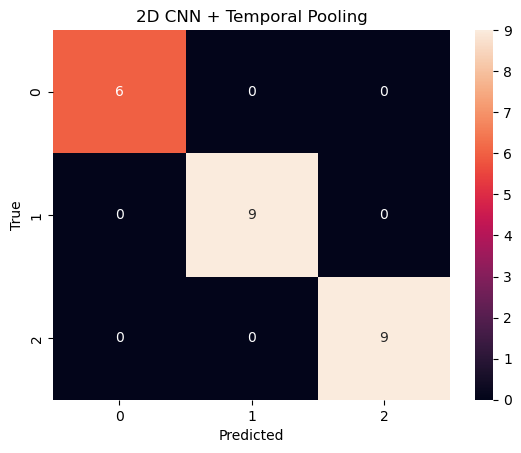

/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R2Plus1D_18_Weights.KINETICS400_V1`. You can also use `weights=R2Plus1D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/r2plus1d_18-91a641e6.pth" to /home/jovyan/.cache/torch/hub/checkpoints/r2plus1d_18-91a641e6.pth
100%|██████████| 120M/120M [00:01<00:00, 65.4MB/s] 



🚀 Training 3D CNN (R(2+1)D)


/opt/conda/lib/python3.11/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch [1/5] - Loss: 1.0240
Epoch [2/5] - Loss: 0.1061
Epoch [3/5] - Loss: 0.0558
Epoch [4/5] - Loss: 0.1795
Epoch [5/5] - Loss: 1.3969

📊 3D CNN (R(2+1)D) Performance
Accuracy            : 0.9583
Precision           : 0.9667
Recall              : 0.9630
F1                  : 0.9628
Train Time          : 64.2426
Inf Time            : 0.0192


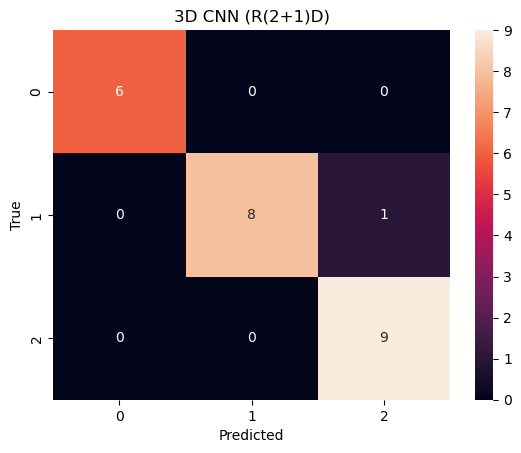

In [14]:
# ==========================================================
# RUN EXPERIMENTS
# ==========================================================
metrics_2d = train_and_evaluate(
    CNN2DTemporal(NUM_CLASSES),
    "2D CNN + Temporal Pooling"
)

metrics_3d = train_and_evaluate(
    CNN3D(NUM_CLASSES),
    "3D CNN (R(2+1)D)"
)

In [ ]:
# ==========================================================
# DETAILED COMPARISON REPORT
# ==========================================================
print("\n" + "="*60)
print("📈 DETAILED MODEL COMPARISON REPORT")
print("="*60)

print("\n🔹 Accuracy Comparison")
print(f"2D CNN Accuracy : {metrics_2d['accuracy']:.4f}")
print(f"3D CNN Accuracy : {metrics_3d['accuracy']:.4f}")

print("\n🔹 Computational Efficiency")
print(f"2D CNN Training Time (s): {metrics_2d['train_time']:.2f}")
print(f"3D CNN Training Time (s): {metrics_3d['train_time']:.2f}")
print(f"2D CNN Inference Time / Video (s): {metrics_2d['inf_time']:.4f}")
print(f"3D CNN Inference Time / Video (s): {metrics_3d['inf_time']:.4f}")

print("\n🔹 Qualitative Analysis")
if metrics_3d["accuracy"] > metrics_2d["accuracy"]:
    print(
        "✔ The 3D CNN outperforms the 2D CNN by explicitly modeling "
        "spatiotemporal patterns, making it more suitable for complex actions."
    )
else:
    print(
        "✔ The 2D CNN achieves competitive accuracy with significantly lower "
        "computational cost, making it suitable for real-time applications."
    )

print(
    "\n🔹 Final Conclusion:\n"
    "2D CNNs provide a strong baseline with efficient inference, while "
    "3D CNNs offer improved performance at the cost of higher computation."
)

print("\n✅ Experiment completed successfully")
